# Libraries with fixed versions and data loading

In [ ]:
!pip install python==3.7.10
!pip install xgboost==1.6.2
!pip install shap==0.41.0
!pip install pandas==1.3.5
!pip install plotly==5.10.0
!pip install scikit-learn==1.0.2
!pip install matplotlib
!pip install seaborn
!pip install dython

In [38]:
import xgboost as xgb
import pandas as pd
import numpy as np
import shap
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import dython

from sklearn.model_selection import train_test_split
from sklearn import metrics

In [39]:
# # Enable export of plotly interactivity in html export
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected = True)

To load the data, you can simply put it on Google Drive and read it in a few lines of code (there are multiple other ways to do it).

For speed, we can load only the provided 26 columns (1 target, 1 ID and 24 features).

In [40]:
ap_train = pd.read_csv('application_train.csv',
                    usecols =  ['TARGET', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
                                'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 
                                'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE',
                                'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 
                                'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'EXT_SOURCE_1', 
                                'EXT_SOURCE_2', 'EXT_SOURCE_3'])
print(f"Application train dataset shape: {ap_train.shape}")

Application train dataset shape: (307511, 26)


For simplicity, we'll create a AGE (in years) variable from DAYS_BIRTH (in days).

In [41]:
ap_train['AGE'] = -round(ap_train['DAYS_BIRTH']/365)
ap_train.drop(columns='DAYS_BIRTH', inplace=True)

# Preparing the data

Let's prepare the data for a simple ML model.

First of all, feature encoding.

In [42]:
ap_train['CODE_GENDER_M'] = np.select([ap_train['CODE_GENDER'] == 'M', ap_train['CODE_GENDER'] == 'F'], [1, 0], default=np.NaN)
ap_train['FLAG_OWN_CAR'] = np.where(ap_train['FLAG_OWN_CAR'] == 'Y', 1, 0)
ap_train['FLAG_OWN_REALTY'] = np.where(ap_train['FLAG_OWN_REALTY'] == 'Y', 1, 0)
ap_train.drop(columns='CODE_GENDER', inplace=True)

In [43]:
ap_objects = list(ap_train.select_dtypes(include=['object']).columns)
ap_train[ap_objects] = ap_train[ap_objects].astype('category')

Let's separate the target from the rest of the data

In [44]:
ap_train_target = ap_train.pop('TARGET')
print(f"Target dataset shape: {ap_train_target.shape}")

Target dataset shape: (307511,)


Let's split the original dataset in two:

*   80% for the train dataset
*   20% for the test one



In [45]:
df_train, df_test, df_target_train, df_target_test = train_test_split(
    ap_train, ap_train_target, test_size=0.2, stratify=ap_train_target, random_state=42)

print(f"Train dataset shape: {df_train.shape}")
print(f"Test dataset shape: {df_test.shape}")

Train dataset shape: (246008, 25)
Test dataset shape: (61503, 25)


# Create a basic ML model and scoring on the test set

I'll train a simple XGBoost model (parameters previously chosen with cross-validation).  

In [46]:
df_train_dmatrix = xgb.DMatrix(df_train.drop(columns='SK_ID_CURR'), df_target_train, enable_categorical=True)

param = {'max_depth':6,
         'eta':.2,
         'subsample':.9,
         'colsample_bytree':.9,
         'scale_pos_weight':10,
         'objective':'binary:logistic',
         'tree_method':'exact'}

xgb_base_model = xgb.train(param, df_train_dmatrix, num_boost_round=50)

Let's score the test set.

In [47]:
df_test_dmatrix = xgb.DMatrix(df_test.drop(columns='SK_ID_CURR'), enable_categorical=True)
xgb_base_test_results = xgb_base_model.predict(df_test_dmatrix)

What are the risk scores (from 0 to 1) of the first 5 customers in the test set? And what's the overall AUC on the test set?

In [48]:
df_test.iloc[:5,:]

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,OCCUPATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AGE,CODE_GENDER_M
256571,396899,Cash loans,1,1,1,157500.0,770292.0,30676.5,688500.0,Family,...,-105,-2876.0,-4402,19.0,Laborers,NaN,0.594327,0.427657,37.0,1.0
191493,322041,Cash loans,0,0,0,90000.0,364896.0,19926.0,315000.0,Family,...,-4930,-4654.0,-1259,NaN,Laborers,0.593554,0.619621,0.484851,49.0,0.0
103497,220127,Cash loans,0,1,0,148500.0,284400.0,18643.5,225000.0,Unaccompanied,...,-1191,-12511.0,-2474,NaN,Security staff,NaN,0.030108,0.538863,66.0,1.0
130646,251531,Cash loans,0,0,0,188100.0,976711.5,38218.5,873000.0,Unaccompanied,...,-355,-969.0,-2289,NaN,Core staff,0.628656,0.417593,0.411849,26.0,0.0
211898,345558,Cash loans,0,1,0,180000.0,323194.5,19660.5,279000.0,Unaccompanied,...,-1366,-10063.0,-1040,NaN,Laborers,NaN,0.355126,0.593718,48.0,0.0


In [49]:
xgb_base_test_results[:5]

array([0.45560062, 0.23749042, 0.7490776 , 0.24548666, 0.49250585],
      dtype=float32)

In [50]:
fpr, tpr, thresholds = metrics.roc_curve(df_target_test, xgb_base_test_results, pos_label=1)
benchm_auc = metrics.auc(fpr, tpr)
print(benchm_auc)

0.7541543982734993


# **[#3] Evaluating feature importance**
## **[#3.1] Evaluating feature importance using built-in xgboost plot_importance**

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

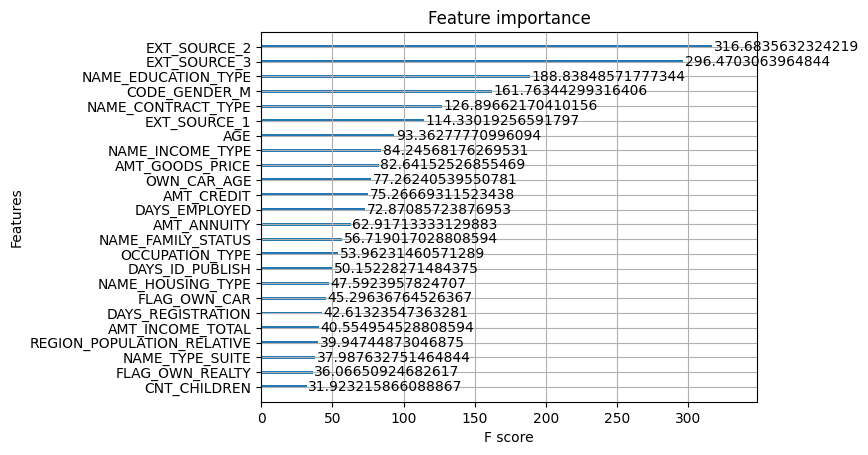

In [14]:
xgb.plot_importance(xgb_base_model, importance_type='gain')

# The Gain is the most relevant attribute to interpret the relative importance of each feature.
# ‘Gain’ is the improvement in accuracy brought by a feature to the branches it is on. The idea is that before adding a new split on a feature X to the branch there was some wrongly classified elements, after adding the split on this feature, there are two new branches, and each of these branch is more accurate

## **[#3.2] Evaluating feature importance using SHAP plot_importance**
## [Interpretation](https://blog.datascienceheroes.com/how-to-interpret-shap-values-in-r/)

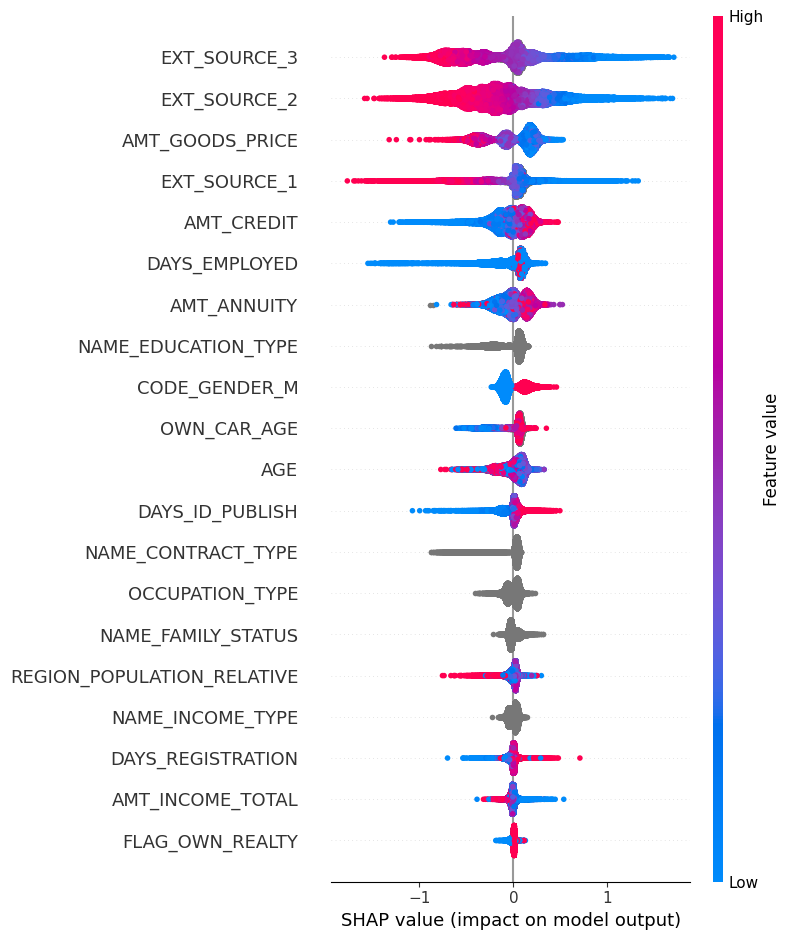

In [15]:
explainer = shap.TreeExplainer(xgb_base_model)
shap_values = explainer.shap_values(df_test_dmatrix)
shap.summary_plot(shap_values, df_test.iloc[:,1:])

# **[#4] Comparing the model predictions with respect to the original training data**
## **[#4.1] Manual correlation matrix after one hot encoding**

In [16]:
df_test.reset_index(drop = True, inplace = True)
xgb_base_test_results = pd.DataFrame(xgb_base_test_results, columns = ['pred'])

test_correlation = pd.concat([df_test, xgb_base_test_results],
                             axis = 1)

test_correlation_dummies = pd.get_dummies(test_correlation)

fig = px.imshow(test_correlation_dummies.corr())
fig.show(renderer = 'browser')

## [#4.2] Correlation matrix using Dython

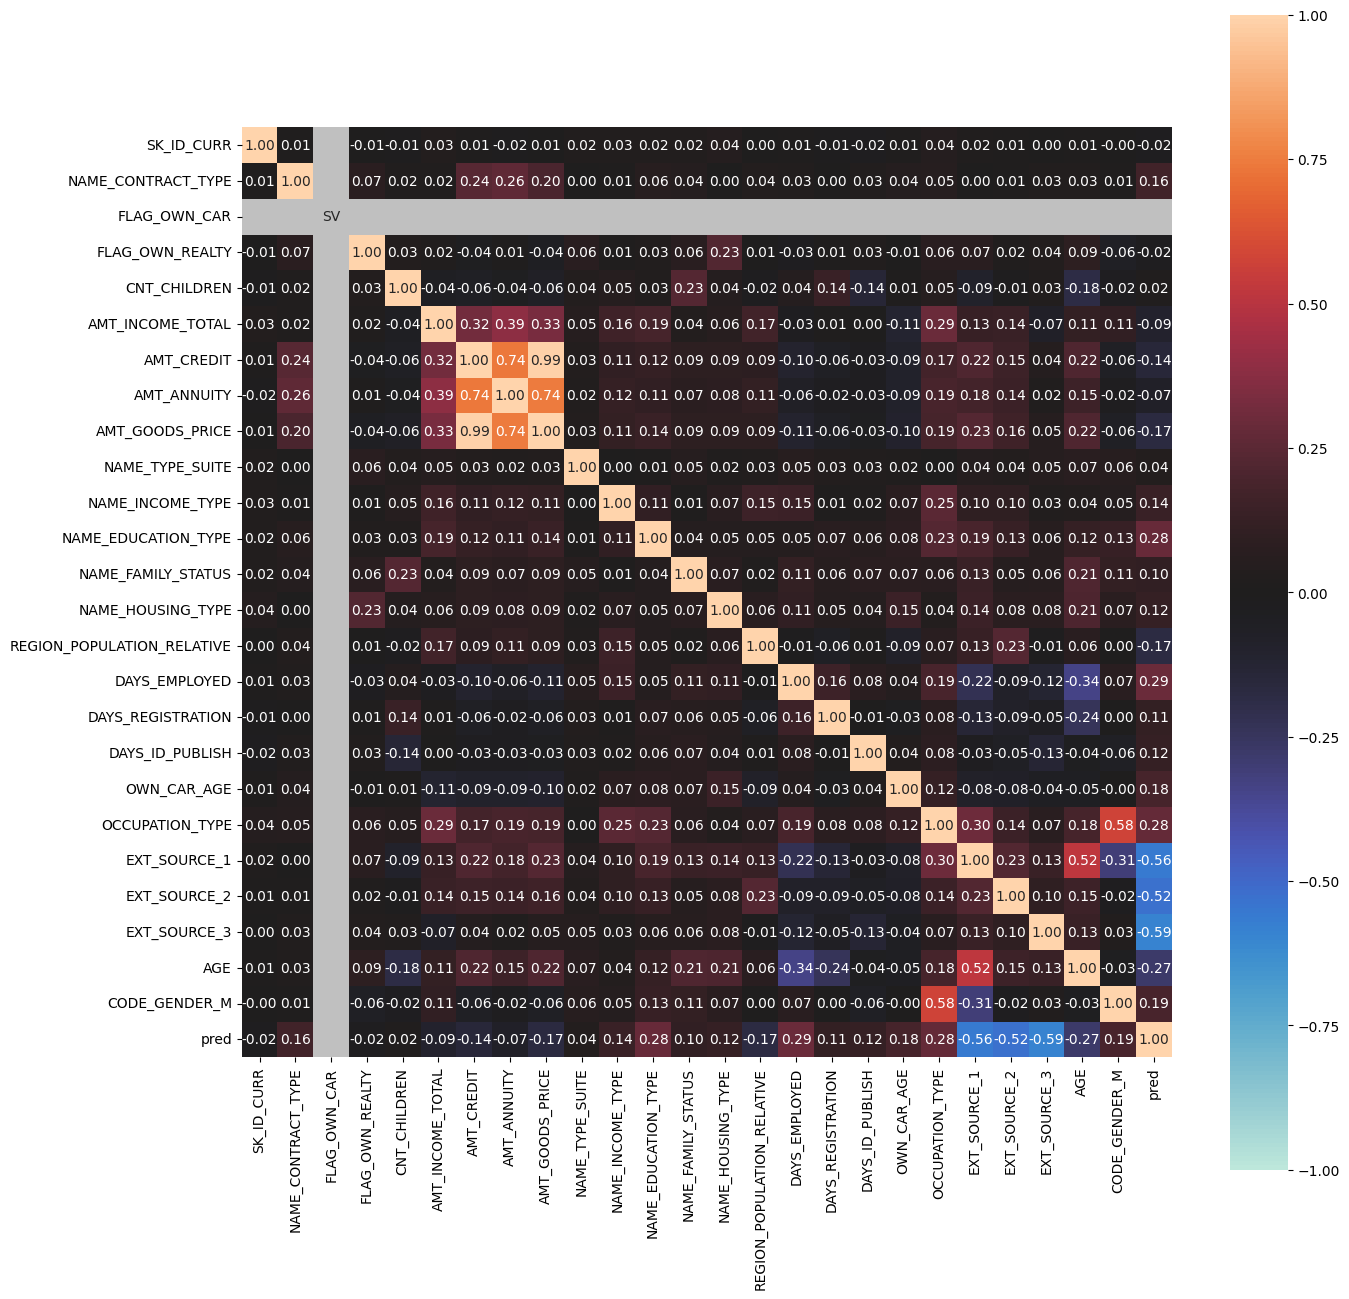

In [17]:
from dython.nominal import associations
complete_correlation = associations(test_correlation, nan_strategy = 'drop_samples', figsize=(15, 15))

# [#5 - #6] Analyze some test record

In [34]:
variables = ['EXT_SOURCE_3', 'AMT_ANNUITY', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'AGE']

def plot_difference(option):
    # option argument could be "singularly" or "together"

    # Defining the "fitting" function, which will repeat in any cases and return the results dictionary
    def fitting():

        # Fit the model and predict
        df_test_dmatrix_mod = xgb.DMatrix(df_test_mod.drop(columns='SK_ID_CURR'),
                                          enable_categorical=True)

        xgb_base_test_results_mod = xgb_base_model.predict(df_test_dmatrix_mod)

        # Store the percentual change in the results dictionary and transform it to a dataframe
        results[change] = metrics.mean_squared_error(df_target_test[:number], xgb_base_test_results_mod)

        results[change] = ((results[change] - benchmark) / benchmark) * 100

        return results

    # Define the number of samples taken as subset of test set
    number = 30

    # Calculate the benchmark performance
    benchmark = metrics.mean_squared_error(df_target_test[:number], xgb_base_test_results[:number])

    if option == 'together':

        # Create a dictionary to store the changes
        results = dict()

        # Iterate over 0 to 100%, with 10% steps
        for change in np.arange(0, 2, 0.1):

            # Take a subset of the test set
            df_test_mod = df_test.iloc[:number, :].copy(deep=True)

            # For each column in the dataset
            for var in df_test_mod:
                # If the column is in the variables we chose:
                if var in variables:
                    # Change the column by the given change
                    df_test_mod[var] = df_test_mod[var] * change

            results = fitting()

        df = pd.DataFrame.from_dict(results, orient = 'index', columns = ['difference'])

    elif option == 'singularly':

        # Define an empty dataset
        df = pd.DataFrame()

        # Iterate over each variable
        for var in variables:

            # Stores the results in a dictionary
            results = dict()

            #For each number in [0%;200%] with 10% step
            for change in np.arange(0, 2, 0.1):

                # Get the copy of the dataset with a length == number
                df_test_mod = df_test.iloc[:number,:].copy(deep = True)

                # Change the column by the given step
                df_test_mod[var] = df_test_mod[var] * change

                results = fitting()

            # Create a temporary dataframe, which has as index the steps and the column is the variable name; the cell is the relative change in the metrics
            temp_df = pd.DataFrame.from_dict(results, orient = 'index', columns = [var])

            # Concatenate the dataframe
            df = pd.concat([df, temp_df], axis = 1)

    # Plot the resulting dataframe
    fig = px.line(df,
                  x = df.index,
                  y = df.columns[:])

    fig.update_xaxes(zeroline=True, zerolinewidth=2, zerolinecolor='Black')
    fig.update_yaxes(zeroline=True, zerolinewidth=2, zerolinecolor='Black')
    fig.update_layout(title="Percentual MSE change of the model vs. percentual change in all variables, changed {}".format(option),
                      xaxis_title="Percentual change in all variables, changed {}".format(option),
                      yaxis_title="Percentual MSE change of the model")

    fig.show(renderer = 'browser')

plot_difference('singularly')

# **[#9] Wrapping up again: what happens by just removing the features of concern**

In [68]:
# Let's list the variable we considered ethical relevant
ethic_var = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
             'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
             'OCCUPATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
             'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'OWN_CAR_AGE']

def removing_ethics():
# option could be 'singularly' or 'together'

    # Enclose the preprocessing lines from the first blocks in the preprocessing function
    def preprocessing():
        ap_train = pd.read_csv('application_train.csv',
                        usecols =  ['TARGET', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
                                    'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                                    'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE',
                                    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
                                    'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'EXT_SOURCE_1',
                                    'EXT_SOURCE_2', 'EXT_SOURCE_3'])
        ap_train['AGE'] = -round(ap_train['DAYS_BIRTH'] / 365)
        ap_train.drop(columns='DAYS_BIRTH', inplace=True)
        ap_train['CODE_GENDER_M'] = np.select([ap_train['CODE_GENDER'] == 'M', ap_train['CODE_GENDER'] == 'F'], [1, 0], default=np.NaN)
        ap_train['FLAG_OWN_CAR'] = np.where(ap_train['FLAG_OWN_CAR'] == 'Y', 1, 0)
        ap_train['FLAG_OWN_REALTY'] = np.where(ap_train['FLAG_OWN_REALTY'] == 'Y', 1, 0)
        ap_train.drop(columns='CODE_GENDER', inplace=True)
        return ap_train

    # Same with processing lines and fitting, return the auc metrics
    def processing_and_fitting():
        ap_objects = list(ap_train.select_dtypes(include=['object']).columns)
        ap_train[ap_objects] = ap_train[ap_objects].astype('category')
        ap_train_target = ap_train.pop('TARGET')
        df_train, df_test, df_target_train, df_target_test = train_test_split(
            ap_train, ap_train_target, test_size=0.2, stratify=ap_train_target, random_state=42)
        df_train_dmatrix = xgb.DMatrix(df_train.drop(columns='SK_ID_CURR'), df_target_train, enable_categorical=True)
        param = {'max_depth': 6,
                 'eta': .2,
                 'subsample': .9,
                 'colsample_bytree': .9,
                 'scale_pos_weight': 10,
                 'objective': 'binary:logistic',
                 'tree_method': 'exact'}
        xgb_base_model = xgb.train(param, df_train_dmatrix, num_boost_round=50)
        df_test_dmatrix = xgb.DMatrix(df_test.drop(columns='SK_ID_CURR'), enable_categorical=True)
        xgb_base_test_results = xgb_base_model.predict(df_test_dmatrix)

        fpr, tpr, thresholds = metrics.roc_curve(df_target_test, xgb_base_test_results, pos_label=1)
        return metrics.auc(fpr, tpr)

    # If option == 'singularly', create a new dictionary to store auc percentual difference in metric, every time you remove an ethical column
    results = dict()
    ap_train = preprocessing()

    # Iterate each column in ap_train
    for col in ap_train:
        ap_train = preprocessing()

        # If the column is ethical, drop it and at each iteration measure the percentual difference in metrics between new metric and the benchmark
        if col in ethic_var:
            ap_train.drop([col], axis=1, inplace = True)
            results[col] = ((processing_and_fitting() - benchm_auc) / benchm_auc) * 100

    # Convert the result dictionary into a dataframe and plot the differences
    df = pd.DataFrame.from_dict(results, orient = 'index', columns=['difference'])

    # Repeat the process, adding to the dataframe related to the difference in performance when you remove all the columns at the same time
    ap_train = preprocessing()
    for col in ap_train:
        if col in ethic_var:
            ap_train.drop([col], axis=1, inplace = True)

    df = pd.concat([df, pd.DataFrame.from_dict({'ALL':processing_and_fitting()}, orient  = 'index', columns = ['difference'])], axis = 0)

    # Plot the resulting dataframe
    fig = px.bar(x=df.index, y=df.difference)

    fig.update_layout(title="Percentual change in AUC when singularly dropping ethical columns on X-axis, or all of them",
                      yaxis_title="Percentual change in AUC compared to benchmark")

    fig.show(renderer = 'browser')

removing_ethics()

# **[#10] Hints at a possible (but questionable!) solution**